$\S$ 데이터에 대한 가중치 행렬 $W_x$, hidden state에 대한 가중치 행렬 $W_h$, 편향 벡터 $b$가 각각
$$
\begin{aligned}
&W_x^{(f)} = W_x^{(i)} =W_x^{(g)} =W_x^{(o)} =\begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}, \\
&W_h^{(f)} = W_h^{(i)} =W_h^{(g)} =W_h^{(o)} =\begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}, \\
&b^{(f)} = b^{(i)} =b^{(g)} =b^{(o)}=[0,0]
\end{aligned}
$$
인 다음과 같은 LSTM층을 생각하자. 여기서 윗첨자 $(f),(i),(g),(o)$는 각각 forget gate, input gate, RNN 변환, output gate의 parameter임을 의미한다.

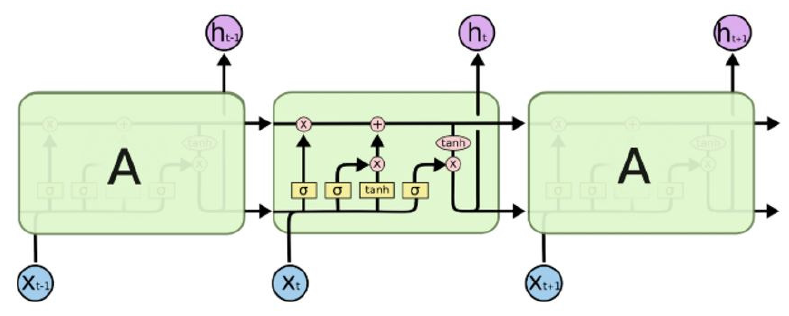

**1. 입력된 데이터 $x_t$와 전 시각의 LSTM층에서 들어온 hidden state $h_{t-1}$, cell state $c_{t-1}$이
$$
x_t=[\log 2, 0], \qquad h_{t-1}=[0,\log 3], \qquad c_{t-1}=[{9 \over 10}, {4 \over 5}]
$$
와 같을 때 다음 시각의 LSTM층에 전달할  hidden state $h_t$와 cell state $c_t$를 구하시오.**

계산의 편의를 위해 각 게이트들의 파라미터들을 모두 동일하게 잡아서 세 게이트는 모두 동일합니다.  
(계산의 편의를 위한것이고 일반적으로 이런 일은 일어나지 않습니다.)  
입력 데이터 $x_t$와 전 시각에서 전달된 hidden state $h_{t-1}$를 Affine변환하면 
$$
\begin{pmatrix}\log 2&0 \end{pmatrix}
\begin{pmatrix}1&0 \\ 0&1\end{pmatrix}
+
\begin{pmatrix}0&\log 3 \end{pmatrix}
\begin{pmatrix}1&0 \\ 0&-1\end{pmatrix}
=
\begin{pmatrix}\log 2&-\log3 \end{pmatrix}
$$
을 얻습니다.  
Affine 변환한 결과에 시그모이드 함수를 취하면 forget, input, output 게이트의 필터
$$
f,i,o = [{1 \over 1+e^{-\log2}}, {1 \over 1+e^{\log3}}] = [{1 \over 1+{1 \over 2}}, {1 \over 1+3}] = [{2 \over 3}, {1 \over 4}]
$$
를 얻습니다.  
Affine 변환한 결과에 쌍곡 탄젠트 함수를 취하면 RNN변환
$$
g = [{e^{2\log2}-1 \over e^{2\log2}+1}, {e^{-2\log3}-1 \over e^{-2\log3}+1}] =
[{4-1 \over 4+1}, {{1 \over 9} -1 \over {1 \over 9} +1}] = [{3 \over 5}, -{4 \over 5}]
$$
입니다.

전시각에서 전달된 cell state $c_{t-1}$에 forget gate의 필터 $f$를 적용하면
$$
f \odot c_{t-1} = [{2 \over 3}, {1 \over 4}] \odot [{9 \over 10}, {4 \over 5}] = [{3 \over 5}, {1 \over 5}]
$$
이 됩니다.  
이는 불필요한 정보를 적절히 잊어버게 해줍니다.

RNN 변환 값 $g$에 input gate의 필터 $i$를 적용하면
$$
i \odot g = [{2 \over 3}, {1 \over 4}] \odot [{3 \over 5}, -{4 \over 5}] = [{2 \over 5}, -{1 \over 5}]
$$
이 됩니다.  
이는 추가할 가치가 있는 정보를 적절히 선별하게 해줍니다.  
적절히 망각하고 남은 정보와 적절히 선별한 추가정보를 더해 다음 시각으로 보낼 cell state
$$
c_t = f \odot c_{t-1} + i \odot g = [1,0]
$$
를 만듭니다.

cell state $c_t$에 쌍곡탄젠트 함수를 취하고 oput gate의 필터 $o$를 적용해  hidden state
$$
h_t = o \odot \tanh c_t = [{2 \over 3}, {1 \over 4}] \odot [{e^2-1 \over e^2+1}, 0] = [{2 \over 3} \times {e^2-1 \over e^2+1}, 0]
$$
를 만듭니다.  
$o$는 출력할 가치있는 정보를 적절히 선별하게 해줍니다.

**2. 다음은 LSTM층의 계산 그래프이다.
흘러들어온 hidden state에 관한 두 미분의 합 $dh_t$와 cell state에 관한 미분 $dc_t$가
$$
dh_t=[0,4], \qquad dc_t=[30,19]
$$
와 같을 때, 계산그래프를 이용하여  $dc_{t-1}$과 slice노드가 밑으로 흘려보내는 미분 $dA$
를 구하시오.**
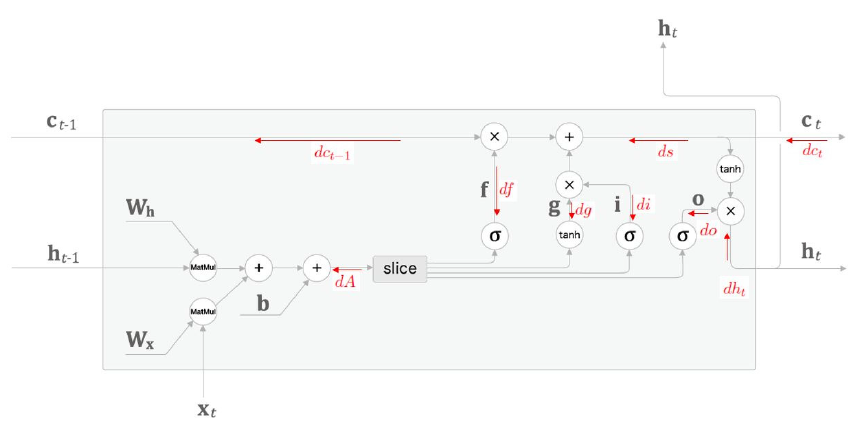

먼저 $ds$를 구해보죠.  
$dh_t$가 곱셈노드를 위쪽으로 통과 후 쌍곡탄젠트 노드를 지나서 나온 값과 $dc_t$를 더하면 $ds$가 됩니다.  
곱셈노드에서는 반대편 순전파 $o$를 곱하고 쌍곡탄젠트 노드에서는 쌍곡 탄젠트의 미분공식 $y'=1-y^2$을 곱합니다.  
계산하면
$$
\begin{aligned}
ds &= dc_t + o \odot dh_t \odot (1-\tanh^2 c_t) \\
&= [30,19] + [{2 \over 3}, {1 \over 4}] \odot [0,4] \odot \left([1-{e^2-1 \over e^2+1}, 1]\right) \\
&= [30,20]
\end{aligned}
$$
이 됩니다.  
$ds$는 덧셈노드는 그냥 통과해서 왼쪽으로 흘러갑니다.  
곱셈노드에서 왼쪽으로 흘러가면 반대편 순전파 $f$와 곱해져서
$$
dc_{t-1} = ds \odot f = [30,20] \odot [{2 \over 3}, {1 \over 4}] = [20,5]
$$
가 나오게 됩니다.

다음은 $dA$를 구해보죠.  
그러기 위해서는 $df, dg, di, do$를 구한후 활성화층을 통과시키고 옆으로 이어 붙이면 됩니다.  
$ds$가 덧셈노드는 그냥 통과해서 왼쪽으로 흘러갑니다.  
곱셈노드에서 아래쪽으로 흘러가면 반대편 순전파 $c_{t-1}$을 곱해서
$$
df = ds \odot c_{t-1} = [30,20] \odot [{9 \over 10}, {4 \over 5}] = [27,16]
$$
를 얻습니다.

$ds$가 덧셈노드는 그냥 통과해서 아래쪽으로 흘러갑니다.  
곱셈노드에서 아래쪽으로 흘러가면 반대편 순전파 $i$를 곱해서
$$
dg = ds \odot i = [30,20] \odot [{2 \over 3}, {1 \over 4}] = [20,5]
$$
를 얻습니다.

$ds$가 덧셈노드는 그냥 통과해서 아래쪽으로 흘러갑니다.  
곱셈노드에서 오른쪽으로 흘러가면 반대편 순전파 $g$를 곱해서
$$
di = ds \odot g = [30,20] \odot [{3 \over 5}, -{4 \over 5}] = [18,-16]
$$
를 얻습니다.

$dh_t$가 곱셈노드를 왼쪽으로 흘러가면 반대편 순전파 $\tanh (c_t)$를 곱해서
$$
do = dh_t \odot \tanh c_t = [0,4] \odot [{e^2 -1\over e^2+1}, 0] = [0,0]
$$
을 얻습니다.

다음은 $df$, $dg$, $di$, $do$가 활성화 층을 통과합니다.  
시그모이드층에서는 흘러들어온 미분에 시그모이드 도함수 공식 $y'=y(1-y)$를 곱하고 쌍곡탄젠트층에서는 흘러들어온 미분에 쌍곡탄젠트 도함수 공식 $y'=1-y^2$을 곱합니다.  
계산하면
$$
\begin{aligned}
f \odot (1-f) \odot df &= [{2 \over 3}, {1 \over 4}] \odot ([{1 \over 3}, {3 \over 4}]) \odot [27,16] = [6,3] \\
(1-g^2) \odot dg &= [1-({3 \over 5})^2, 1-(-{4 \over 5})^2] \odot [20,5] = [{64 \over 5},{9 \over 5}] \\
i \odot (1-i) \odot di &= [{2 \over 3}, {1 \over 4}] \odot ([{1 \over 3}, {3 \over 4}]) \odot [18,-16] = [4,-3] \\
o \odot (1-o) \odot do &= [{2 \over 3}, {1 \over 4}] \odot ([{1 \over 3}, {3 \over 4}]) \odot [0,0] = [0,0]
\end{aligned}
$$
와 같습니다.  
옆으로 이어붙여서
$$
dA = [6,3,{64 \over 5},{9 \over 5},4,-3,0,0]
$$
을 얻습니다.

**3. LSTM 클래스를 사용하여 검산하시오.**

In [1]:
import sys
sys.path.append('C://Users//HAN//Documents//Deep Learning from Scratch 2') # 각자의 경로로 수정해주세요.
import numpy as np
from common.time_layers import LSTM

데이터에 대한 가중치 행렬 4개를 옆으로 이어 붙입니다.  
hidden state에 대한 가중치 행렬 4개도 옆으로 이어 붙입니다.  
편향벡터 4개도 옆으로 이어 붙입니다.

In [2]:
Wx = np.array([[1,0,1,0,1,0,1,0,],[0,1,0,1,0,1,0,1]])
Wh = np.array([[1,0,1,0,1,0,1,0,],[0,-1,0,-1,0,-1,0,-1]])
b = np.zeros(8)

lstm = LSTM(Wx,Wh,b)

In [3]:
x = np.array([[np.array(np.log(2)),0]])
h_prev = np.array([[0,np.log(3)]])
c_prev = np.array([[9/10,4/5]])

h_next, c_next = lstm.forward(x, h_prev, c_prev)

print("hidden state : "+str(h_next))
print("cell state : "+str(c_next))

hidden state : [[0.50772944 0.        ]]
cell state : [[1. 0.]]


손계산 결과와 맞아 떨어지네요.

In [4]:
print(2/3 * (np.exp(2)-1)/(np.exp(2)+1))

0.5077294373038432


In [5]:
dh_next = np.array([[0,4]])
dc_next = np.array([[30,19]])

dx, dh_prev, dc_prev = lstm.backward(dh_next, dc_next)

print("cell state에 대한 미분 : "+str(dc_prev))

print("dA : "+str(lstm.grads[2]))

cell state에 대한 미분 : [[20.  5.]]
dA : [ 6.   3.  12.8  1.8  4.  -3.   0.   0. ]
